In [29]:
import sys
sys.path.insert(0, "/home/bill/pymc3/")

import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm
import numpy as np
import scipy as sp
import scipy.stats
import scipy.linalg

import theano
import theano.tensor as tt

from oct2py import octave

# sketch of gpml implementation of exact gp inference

In [30]:
## transcoding gpml exact

x = np.linspace(0,1,50)[:,None]
l = 0.2
Kmat = theano.function([], pm.gp.cov.ExpQuad(1, l)(x))()
y = np.random.multivariate_normal(np.zeros(50), Kmat, 1).flatten()
sn2 = 0.1  # sn2 = exp( 2 * hyp.lik)

""" function [post, nlZ, dnLZ] = infGaussLik(hyp, mean, cov, lik, x, y, opt)
"""

n, D = x.shape

### evaluate mean vector and derivatives
# m, dm = mean(x)
m = np.zeros(n)
W = np.ones(n) / sn2

## call to apx:  
""" K = apx(hyp, cov, x, opt)
"""

class Kclass(object):
    def __init__(self, K):
        self.K = K
        self.dK = None
    def mvm(self, x):
        return np.dot(self.K, x)
    def fun(self,W):
        return ldB2_exact(W, self.K, self.dK)
    def P(self, x):
        return x
    def Pt(self, x):
        return x

def ldB2_exact(W, K, dK):
    n = W.size
    sW = np.sqrt(W)
    # np.outer(sW, sW) creates a n x n constant matrix of what the entries in W are
    L = sp.linalg.cholesky(np.eye(n) + np.outer(sW, sW) * K, lower=False) # cholesky factor of "B"
    ldB2 = np.sum(np.log(np.diag(L)))                         # logdet(B)/2
    
    # check the bsxfun calls that are in solveKiW
    # solveKiW = @(r) bsxfun(@times,solve_chol(L,bsxfun(@times,r,sW)),sW);
    def solveKiW(r): # r = y - m
        return solve_chol(L, r * sW) * sW  # is r a vector or matrix?
    
    dW = None
    dldB2 = None
    return ldB2, solveKiW, dW, dldB2, L
         
def solve_chol(L, x):
    return np.linalg.solve(L, np.linalg.solve(L.T, x))
            
# back in infGaussLik here
K = Kclass(Kmat)
ldB2, solveKiW, dW, dhyp, postL = K.fun(W)
alpha = solveKiW(y - m)
postalpha = K.P(alpha) # does nothing here
postsW = np.sqrt(W)
nlZ = np.dot((y - m).T , alpha/2) + ldB2 + n * np.log(2 * np.pi * sn2) / 2.0 
print(nlZ)






""" Normal, non matlabby version
"""
nlZ2 = -sp.stats.multivariate_normal.logpdf(y, mean=m, cov=Kmat + 1e-8*np.eye(50))
print(nlZ2)
print(nlZ2 / nlZ)

2.04223693313
-310.756059933
-152.164548046


/home/bill/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: covariance is not positive-semidefinite.


# Direct implementation of gpml exact inference
## Python

In [31]:
x = np.linspace(0,1,50)[:,None]
l = 0.2
Kmat = theano.function([], pm.gp.cov.ExpQuad(1, l)(x))()
y = np.random.multivariate_normal(np.zeros(50), Kmat, 1).flatten()

n, D = x.shape
m = np.zeros(n)
W = np.ones(n) / sn2

sW = np.sqrt(W)
L = sp.linalg.cholesky(np.eye(n) + np.outer(sW, sW) * Kmat, lower=False)
ldB2 = np.sum(np.log(np.diag(L)))

r = y - m
alpha = solve_chol(L, r * sW) * sW
print(alpha.shape)
nlZ = np.dot(y - m , alpha/2) + ldB2 + n * np.log(2 * np.pi * sn2) / 2.0 
print(nlZ)

nlZ2 = -sp.stats.multivariate_normal.logpdf(y, mean=m, cov=Kmat + sn2*np.eye(50))
print(nlZ2)

(50,)
6.51686176821
6.51686176821


/home/bill/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: covariance is not positive-semidefinite.


## Octave

In [32]:
octave.push("Kmat", Kmat)
octave.push("y", y)
octave.push("x", x)
octave.push("l", l)
octave.push("sn2", sn2)

octave.eval("""

function x = solve_chol(A, B)
  if nargin ~= 2 | nargout > 1
    error('Wrong number of arguments.');
  end

  if size(A,1) ~= size(A,2) | size(A,1) ~= size(B,1)
    error('Wrong sizes of matrix arguments.');
  end

  x = A\(A'\B);
end


function [ldB2,solveKiW,dW,dldB2,L] = ldB2_exact(W,K,dK)
  isWneg = any(W<0); n = numel(W);
  if isWneg                  % switch between Cholesky and LU decomposition mode
    A = eye(n) + bsxfun(@times,K,W');                     % asymmetric A = I+K*W
    [L,U,P] = lu(A); u = diag(U);         % compute LU decomposition, A = P'*L*U
    signU = prod(sign(u));                                           % sign of U
    detP = 1;               % compute sign (and det) of the permutation matrix P
    p = P*(1:n)';
    for i=1:n                                                     % swap entries
      if i~=p(i), detP = -detP; j = find(p==i); p([i,j]) = p([j,i]); end
    end
    if signU~=detP     % log becomes complex for negative values, encoded by inf
      ldB2 = Inf;
    else          % det(L) = 1 and U triangular => det(A) = det(P)*prod(diag(U))
      ldB2 = sum(log(abs(u)))/2;
    end                                            % compute inverse if required
    if nargout>1, Q = U\(L\P); solveKiW = @(r) bsxfun(@times,W,Q*r); end
    if nargout>4, L = -diag(W)*Q; end                              % overwrite L
  else                                                 % symmetric B = I+sW*K*sW
    sW = sqrt(W); L = chol(eye(n)+sW*sW'.*K);             % Cholesky factor of B
    ldB2 = sum(log(diag(L)));                                    % log(det(B))/2
    solveKiW = @(r) bsxfun(@times,solve_chol(L,bsxfun(@times,r,sW)),sW);
    if nargout>2, Q = bsxfun(@times,1./sW,solve_chol(L,diag(sW))); end
  end
  if nargout>2
    dW = sum(Q.*K,2)/2;            % d log(det(B))/2 / d W = diag(inv(inv(K)+W))
    dldB2 = @(varargin) ldB2_deriv_exact(W,dK,Q, varargin{:});     % derivatives
  end
end


y = y';
[n, D] = size(x);
W = ones(n, 1)/sn2;
m = zeros(n, D);

dK = 1;
K = struct('mvm',@(x)Kmat*x, 'fun',@(W)ldB2_exact(W,Kmat,dK), ...  % mvm and fun
           'P',@(x)x, 'Pt',@(x)x);

[ldB2,solveKiW,dW,dhyp,post.L] = K.fun(W); % obtain functionality depending on W

alpha = solveKiW(y-m);
nlZ = (y-m)'*alpha/2 + ldB2 + n*log(2*pi*sn2)/2;

disp(nlZ)

""")

 6.5169


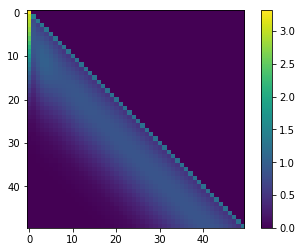

In [33]:
sW = np.sqrt(W)
L1 = np.linalg.cholesky(np.eye(Kmat.shape[0]) + np.outer(sW, sW) * Kmat)
m=plt.imshow(L1);
plt.colorbar(m);

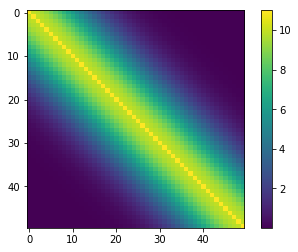

In [34]:
B = np.eye(Kmat.shape[0]) + np.outer(sW, sW) * Kmat
m = plt.imshow(B)
plt.colorbar(m)

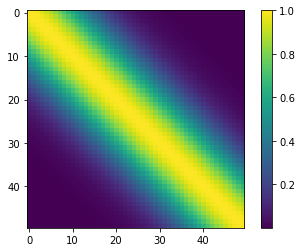

In [35]:
m = plt.imshow(Kmat)
plt.colorbar(m)

## GPML FITC / VFE
### Octave

In [53]:
n = 10
x = np.linspace(0,1,n)[:,None]
l = 0.2
Kmat = theano.function([], pm.gp.cov.ExpQuad(1, l)(x))()
y = np.random.multivariate_normal(np.zeros(n), Kmat + 1e-8*np.eye(n), 1).flatten()

n, D = x.shape
m = np.zeros(n)
W = np.ones(n) / sn2

s = 0.5 # s = 0.0 for VFE, s = 1.0 for FITC
xu = np.linspace(0,1,5)[:,None]
nu = np.shape(xu)[0]

Kuu = theano.function([], pm.gp.cov.ExpQuad(1, l)(xu))()
Ku  = theano.function([], pm.gp.cov.ExpQuad(1, l)(xu, x))()
diagK = np.diag(Kmat)


octave.push("Kmat", Kmat)
octave.push("Kuu",  Kuu)
octave.push("Ku",   Ku)
octave.push("diagK", diagK)
octave.push("y", y)
octave.push("x", x)
octave.push("l", l)
octave.push("sn2", sn2)
octave.push("xu", xu)
octave.push("s", s)

octave.eval(r"""

function x = solve_chol(A, B)
  if nargin ~= 2 | nargout > 1
    error('Wrong number of arguments.');
  end

  if size(A,1) ~= size(A,2) | size(A,1) ~= size(B,1)
    error('Wrong sizes of matrix arguments.');
  end

  x = A\(A'\B);
end

function [ldB2,solveKiW,dW,dldB2,L]=ldB2_sparse(W,V,g,Luu,dKuu,dKu,ddiagK,s,xud)
  z = s*g.*W; t = 1/s*log(z+1); i = z<1e-4;  % s=0: t = g*W, s=1: t = log(g*W+1)
  t(i) = g(i) .* W(i) .* (1 - z(i)/2 + z(i).^2/3);         % 2nd order Taylor for tiny z
  dt = 1./(z+1); d = W.*dt;                               % evaluate derivatives
  nu = size(Luu,1); Vd = bsxfun(@times,V,d');
  Lu = chol(eye(nu) + V*Vd'); LuV = Lu'\V;               % Lu'*Lu=I+V*diag(d)*V'
  ldB2 = sum(log(diag(Lu))) + sum(t)/2;    % s=1 => t=log(g.*W+1), s=0 => t=g.*W
  md = @(r) bsxfun(@times,d,r); solveKiW = @(r) md(r) - md(LuV'*(LuV*md(r)));
  if nargout>2                % dW = d log(det(B))/2 / d W = diag(inv(inv(K)+W))
    dW = sum(LuV.*((LuV*Vd')*V),1)' + s*g.*d.*sum(LuV.*LuV,1)';
    dW = dt.*(g+sum(V.*V,1)'-dW)/2;                % add trace "correction" term
    dldB2 = @(varargin) ldB2_deriv_sparse(V,Luu,d,LuV,dKuu,dKu,ddiagK,s,xud,...
                                                                   varargin{:});
    if nargout>4
      L = solve_chol(Lu*Luu,eye(nu))-solve_chol(Luu,eye(nu));   % Sigma-inv(Kuu)
    end
  end
end




y = y';
[n, D] = size(x);
W = ones(n, 1)/sn2;
m = zeros(n, D);
nu = size(xu, 1);
diagK = diagK';

snu2 = 1e-6*(trace(Kuu)/nu);                 % stabilise by 0.1% of signal std
Luu  = chol(Kuu+snu2*eye(nu));                       % Kuu + snu2*I = Luu'*Luu
V  = Luu'\Ku;                                   % V = inv(Luu')*Ku => V'*V = Q
g = max(diagK-sum(V.*V,1)',0);                         % g = diag(K) - diag(Q)

K.mvm = @(x) V'*(V*x) + bsxfun(@times, s*g, x); % efficient matrix-vector mult
K.P   = @(x) Luu\(V*x);                                       % projection ops
K.Pt  = @(x) V'*(Luu'\x);                                     % projection ops
K.fun = @(W) ldB2_sparse(W, V, g, Luu, 1,1,1,s, false);
[ldB2, solveKiW] = K.fun(W);

alpha = solveKiW(y-m);
nlZ = (y-m)'*alpha/2 + ldB2 + n*log(2*pi*sn2)/2;

disp(nlZ)

""")

 7.9118


## Python

In [54]:
n, D = x.shape
m = np.zeros(n)
W = np.ones(n) / sn2

s = 0.5 # s = 0.0 for VFE, s = 1.0 for FITC
xu = np.linspace(0,1,5)[:,None]
nu = np.shape(xu)[0]

Kuu = theano.function([], pm.gp.cov.ExpQuad(1, l)(xu))()
Ku  = theano.function([], pm.gp.cov.ExpQuad(1, l)(xu, x))()
diagK = np.diag(Kmat)

snu2 = 1e-6 * (np.trace(Kuu)/nu)
Luu = sp.linalg.cholesky(Kuu + snu2*np.eye(nu), lower=False)
V = np.linalg.solve(Luu.T, Ku)
g = np.clip(diagK - np.sum(V*V, 0), 0.0, np.inf)

## ldB2_sparse
z = s * g * W
t = (1.0 / s) * np.log(z + 1.0)
i = z < 1e-4
t[i] = g[i] * W[i] * (1.0 - z[i]/2.0 + np.square(z[i])/3.0)
dt = 1.0 / (z + 1.0)
d = W * dt
nu = np.shape(Luu)[0]
Vd = V * d  # bsxfun(@times, V, d.T)
Lu = sp.linalg.cholesky(np.eye(nu) + np.dot(V, Vd.T))
LuV = np.linalg.solve(Lu.T, V)
ldB2 = np.sum(np.log(np.diag(Lu))) + np.sum(t)/2.0

r = y - m
alpha = d*r - d*np.dot(LuV.T, np.dot(LuV, d*r))
nlZ = np.dot(r, alpha/2.0) + ldB2 + n*np.log(2*np.pi*sn2)/2.0
print(nlZ)

7.91178393918


## FITC (with s = 1.0)

In [63]:
n, D = x.shape
m = np.zeros(n)
W = np.ones(n) / sn2

xu = np.linspace(0,1,5)[:,None]
nu = np.shape(xu)[0]

Kuu = theano.function([], pm.gp.cov.ExpQuad(1, l)(xu))()
Ku  = theano.function([], pm.gp.cov.ExpQuad(1, l)(xu, x))()
diagK = np.diag(Kmat)

snu2 = 1e-6 * (np.trace(Kuu)/nu)
Luu = sp.linalg.cholesky(Kuu + snu2 * np.eye(nu), lower=True)
# V = inv(Luu')*Ku => V'*V = Q
V = sp.linalg.solve_triangular(Luu, Ku, lower=True) 
g = np.clip(diagK - np.sum(V*V, 0), 0.0, np.inf)

## ldB2_sparse
z = g * W
t = np.log(z + 1.0)
i = z < 1e-4
t[i] = g[i] * W[i] * (1.0 - z[i]/2.0 + np.square(z[i])/3.0)

dt = 1.0 / (z + 1.0)
d = W * dt
nu = np.shape(Luu)[0]
Vd = V * d  # bsxfun(@times, V, d.T)
Lu = sp.linalg.cholesky(np.eye(nu) + np.dot(V, Vd.T))
LuV = np.linalg.solve(Lu.T, V)
ldB2 = np.sum(np.log(np.diag(Lu))) + np.sum(t)/2.0

r = y - m
alpha = d*r - d*np.dot(LuV.T, np.dot(LuV, d*r))
nlZ = np.dot(r, alpha/2.0) + ldB2 + n*np.log(2*np.pi*sn2)/2.0
print(nlZ)

## Predict
z = np.linspace(-0.1, 1.1, 100)[:,None]
Ksx = theano.function([], pm.gp.cov.ExpQuad(1, l)(z, x))()
ymu = np.dot(Ksx, alpha)

Kss = theano.function([], pm.gp.cov.ExpQuad(1, l)(z, z))()
Sigma = Kss - np.dot(alpha, sp.linalg.solve(Ksx, y))

plt.plot(x, y, 'o');
plt.plot(z, ymu);

7.67027145241


ValueError: Input a needs to be a square matrix.

## Chol solve, upper vs lower

upper is used in GPML, lower used in PyMC3

also shown is solve triangular

computes 

$$
x = K^{-1}b
$$

In [27]:
A = np.random.randn(5,5)
K = np.dot(A, A.T) + 1e-7 * np.eye(5)
b = np.random.randn(5)

Lu = sp.linalg.cholesky(K, lower=False)
Ll = sp.linalg.cholesky(K, lower=True)

#x = A\(A'\B);
print("upper", sp.linalg.solve(Lu, sp.linalg.solve(Lu.T, b)))
print("lower", sp.linalg.solve(Ll.T, sp.linalg.solve(Ll, b)))
print("upper", sp.linalg.solve_triangular(Lu, sp.linalg.solve_triangular(Lu.T, b, lower=True), lower=False))
print("lower", sp.linalg.solve_triangular(Ll.T, sp.linalg.solve_triangular(Ll, b, lower=True), lower=False))

upper [-24.44722801  53.52702245  16.69296591  10.30985056  35.17834781]
lower [-24.44722801  53.52702245  16.69296591  10.30985056  35.17834781]
upper [-24.44722801  53.52702245  16.69296591  10.30985056  35.17834781]
lower [-24.44722801  53.52702245  16.69296591  10.30985056  35.17834781]
